<a href="https://colab.research.google.com/github/mu06905/GPU-Accelerated-Programming-in-Cuda-2023/blob/main/Week5/cocentricCirclesSharedMem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-ywwcx499
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-ywwcx499
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=78d4932e73cd08a08499756b923bbef44a3cb6f7f83c2a5120763e787a6fa6dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-ohz5s41k/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [18]:
%%cu 
#include <stdio.h>
#include <cuda.h>

const int WIDTH = 512;
const int HEIGHT = 512;
const int SIZE = WIDTH*HEIGHT;
const int IMAGE_SIZE_IN_BYTES = SIZE * sizeof(unsigned char)*4;

__global__ void cocentric_circles(unsigned char* pData){
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    float centerX = (WIDTH)/2;
    float centerY = (HEIGHT)/2;

    int offset = y * WIDTH + x;

    float distance = sqrt((centerX - x) * (centerX - x) + (centerY - y) * (centerY - y));
    float value = fmod(distance,20.f);
    
    int pixelValue = (value<10.0)?255:0;

    pData[offset * 4 + 0] = 0;
    pData[offset * 4 + 1 ] = pixelValue;
    pData[offset * 4 + 2] = 0;
    pData[offset * 4 + 3] = 255;
    
}
void save_raw_image(const char* imageName, unsigned char* pData)
{
	FILE* fp = fopen(imageName, "wb");
	if (fp)
	{
		fwrite(pData, 4*sizeof(unsigned char), SIZE, fp);
		fclose(fp);
	}
	else
	{
		puts("Cannot write raw image.");
	}
}
int main(){
    
    unsigned char* h_image = (unsigned char*)malloc(IMAGE_SIZE_IN_BYTES);

    unsigned char* d_image;
    cudaMalloc(&d_image, IMAGE_SIZE_IN_BYTES);

    
    dim3 blocksGrid;
    dim3 threadsBlock(16,16,1);
    blocksGrid.x = ceil(WIDTH/16.0);
    blocksGrid.y = ceil(HEIGHT/16.0);


    cocentric_circles<<<blocksGrid,threadsBlock>>>(d_image);
    printf("%f\n",ceil( WIDTH/16.0));

    cudaMemcpy(h_image,d_image, IMAGE_SIZE_IN_BYTES, cudaMemcpyDeviceToHost);
    
    save_raw_image("/content/OutputImage.raw", h_image);

    cudaFree(d_image);
    free(h_image);


    return 0;
}



32.000000



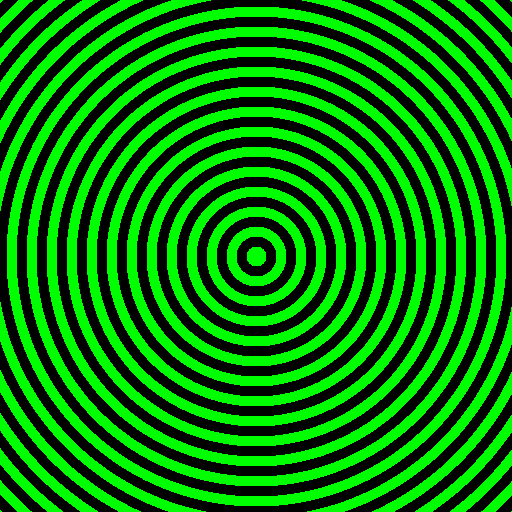

In [19]:
import numpy as np

#lets view our image 
fd = open('/content/OutputImage.raw', 'rb')
rows = 512
cols = 512
f = np.fromfile(fd, dtype=np.uint8,count=rows*cols*4)
im = f.reshape((rows, cols, 4)) #notice row, column format
fd.close()

from google.colab.patches import cv2_imshow
#display image using cv2_imshow
cv2_imshow(im)